<a href="https://colab.research.google.com/github/hrnnikolov/ML_models/blob/main/PyTorch_paper_replicating.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# For this notebook to run with updated APIs, we need torch 1.12+ and torchvision 0.13+
try:
    import torch
    import torchvision
    assert int(torch.__version__.split(".")[1]) >= 12 or int(torch.__version__.split(".")[0]) == 2, "torch version should be 1.12+"
    assert int(torchvision.__version__.split(".")[1]) >= 13, "torchvision version should be 0.13+"
    print(f"torch version: {torch.__version__}")
    print(f"torchvision version: {torchvision.__version__}")
except:
    print(f"[INFO] torch/torchvision versions not as required, installing nightly versions.")
    !pip3 install -U torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu118
    import torch
    import torchvision
    print(f"torch version: {torch.__version__}")
    print(f"torchvision version: {torchvision.__version__}")

torch version: 2.2.1+cu121
torchvision version: 0.17.1+cu121


In [2]:
# Continue with regular imports
import matplotlib.pyplot as plt
import torch
import torchvision

from torch import nn
from torchvision import transforms

# Try to get torchinfo, install it if it doesn't work
try:
    from torchinfo import summary
except:
    print("[INFO] Couldn't find torchinfo... installing it.")
    !pip install -q torchinfo
    from torchinfo import summary

# Try to import the going_modular directory, download it from GitHub if it doesn't work
try:
    from going_modular.going_modular import data_setup, engine
    from helper_functions import download_data, set_seeds, plot_loss_curves
except:
    # Get the going_modular scripts
    print("[INFO] Couldn't find going_modular or helper_functions scripts... downloading them from GitHub.")
    !git clone https://github.com/mrdbourke/pytorch-deep-learning
    !mv pytorch-deep-learning/going_modular .
    !mv pytorch-deep-learning/helper_functions.py . # get the helper_functions.py script
    !rm -rf pytorch-deep-learning
    from going_modular.going_modular import data_setup, engine
    from helper_functions import download_data, set_seeds, plot_loss_curves

[INFO] Couldn't find torchinfo... installing it.
[INFO] Couldn't find going_modular or helper_functions scripts... downloading them from GitHub.
Cloning into 'pytorch-deep-learning'...
remote: Enumerating objects: 4056, done.
remote: Total 4056 (delta 0), reused 0 (delta 0), pack-reused 4056
Receiving objects: 100% (4056/4056), 646.90 MiB | 17.92 MiB/s, done.
Resolving deltas: 100% (2372/2372), done.
Updating files: 100% (248/248), done.


In [3]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cpu'

In [4]:
# Download pizza, steak, sushi images from GitHub
image_path = download_data(source="https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi.zip",
                           destination="pizza_steak_sushi")
image_path

[INFO] Did not find data/pizza_steak_sushi directory, creating one...
[INFO] Downloading pizza_steak_sushi.zip from https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi.zip...
[INFO] Unzipping pizza_steak_sushi.zip data...


PosixPath('data/pizza_steak_sushi')

In [5]:
train_dir = image_path / 'train'
test_dir = image_path / 'test'

In [6]:
from going_modular.going_modular import data_setup
from torchvision import transforms

IMAGE_SIZE = 224

mannual_transforms = transforms.Compose([transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),
                                        transforms.ToTensor()])

In [7]:
BATCH_SIZE = 32

# Create DataLoaders

train_dataloader, test_dataloader, class_names = data_setup.create_dataloaders(train_dir=train_dir,
                                                                               test_dir=test_dir,
                                                                               transform=mannual_transforms,
                                                                               batch_size=BATCH_SIZE)

train_dataloader, class_names

(<torch.utils.data.dataloader.DataLoader at 0x78756b1002b0>,
 ['pizza', 'steak', 'sushi'])

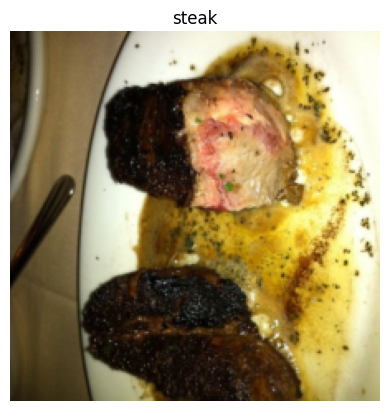

In [8]:
# Visualize a single image
import matplotlib.pyplot as plt

image_batch, image_label = next(iter(train_dataloader))

img, label = image_batch[0], image_label[0]

plt.imshow(img.permute(2, 1, 0))
plt.title(class_names[label])
plt.axis('off');

# Replicating VIT

In [9]:
#Create example balues
height = 224
width = 224
color_channels = 3
patch_size = 16

#Calculate number of patches
number_of_patches = int((height * width) / patch_size**2)
number_of_patches

196

In [10]:
# input shape
embedding_layer_input_shape = (height, width, color_channels)

# output shape
embedding_layer_output_shape = (number_of_patches, patch_size**2 * color_channels)

print(f'Input {embedding_layer_input_shape}')
print(f'Output {embedding_layer_output_shape}')

Input (224, 224, 3)
Output (196, 768)


# Turning a picture into pathes

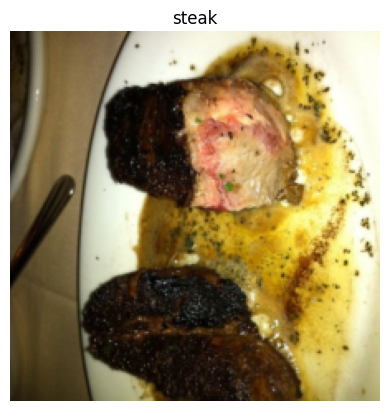

In [11]:
plt.imshow(img.permute(2, 1, 0))
plt.title(class_names[label])
plt.axis('off');

In [12]:
img.shape

torch.Size([3, 224, 224])

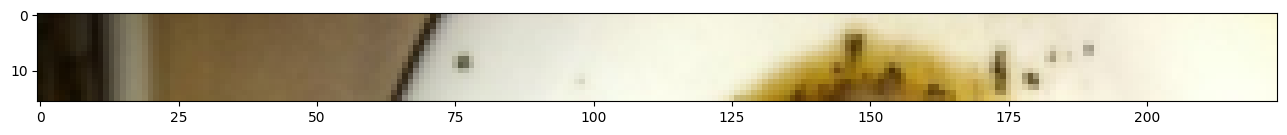

In [13]:
#get the top row
permuted_image = img.permute(2, 1, 0)

path_size = 16
plt.figure(figsize=(patch_size, patch_size))
plt.imshow(permuted_image[:patch_size, :,  :])

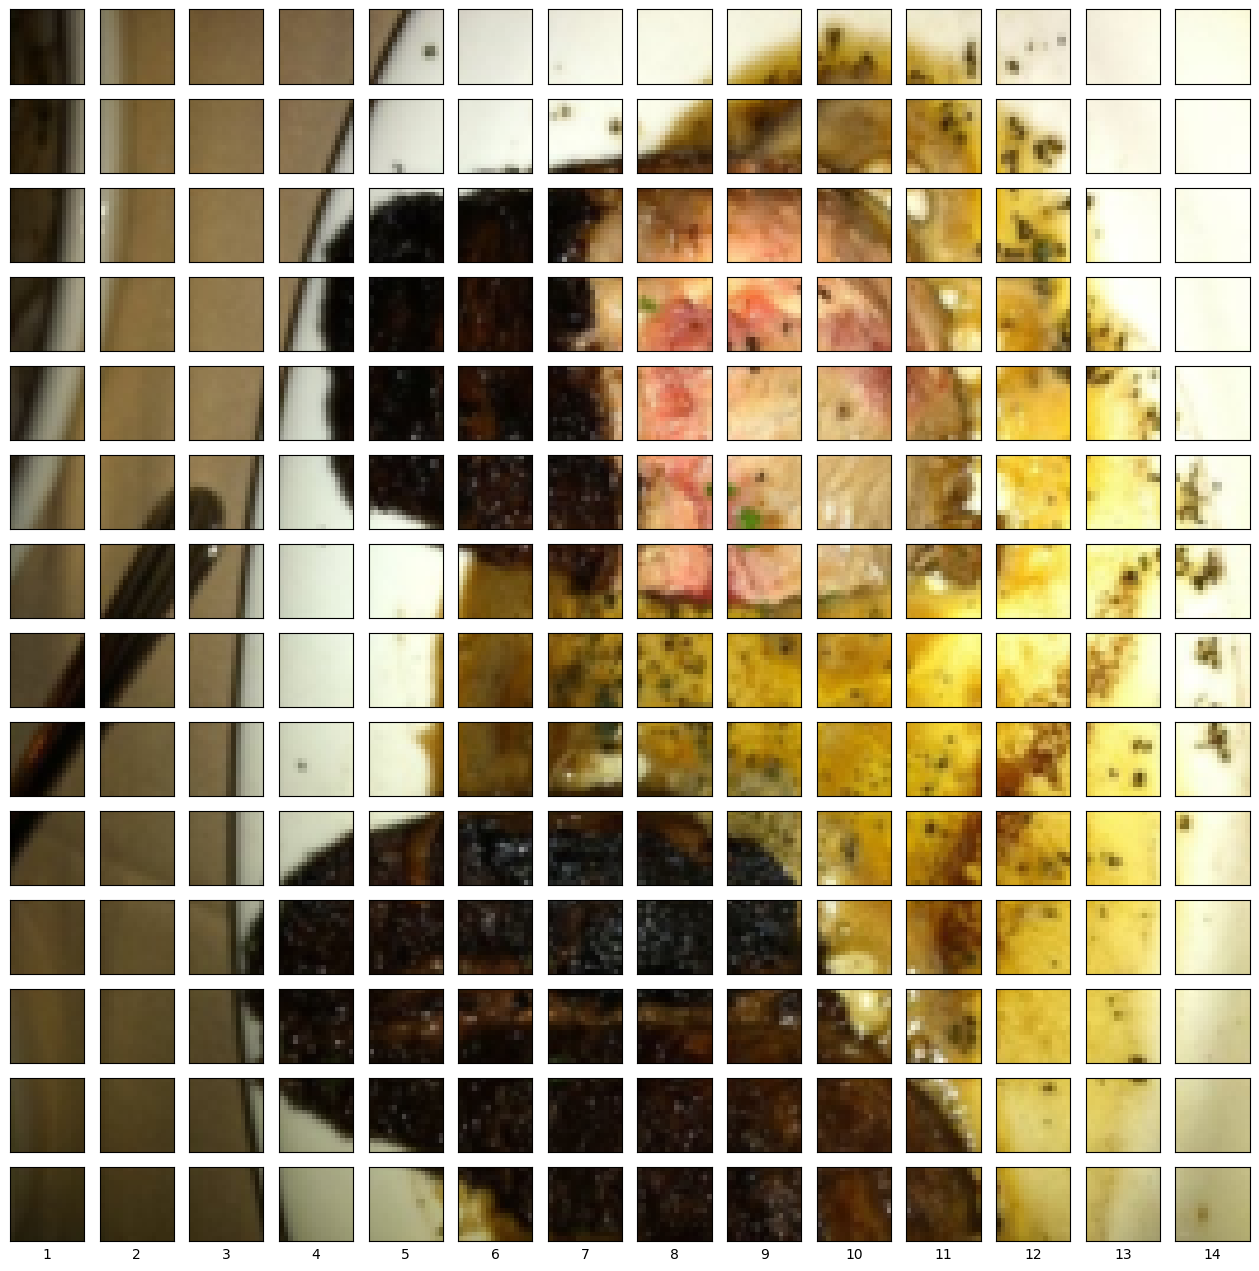

In [14]:
img_size = 224
patch_size = 16
num_patches = img_size / patch_size

assert img_size % patch_size == 0, 'Image size must be devisible by patch size'

#create a series of subplots

fig, axs = plt.subplots(nrows=img_size // patch_size,
                        ncols=img_size // patch_size,
                        sharex=True,
                        sharey=True,
                        figsize=(patch_size,patch_size))

# itter through number of patches
# x_label_num = 0

for j, rowpatch in enumerate(range(0, img_size, patch_size)):
  for i, colpatch in enumerate(range(0, img_size, patch_size)):
    #x_label_num += 1
    axs[j][i].imshow(permuted_image[rowpatch:rowpatch+patch_size, colpatch:colpatch+patch_size, :]);
    axs[j][i].set_xlabel(i+1)
    axs[j][i].set_xticks([])
    axs[j][i].set_yticks([])
    axs[j, i].label_outer()

# Creating image patches and turning them into patch embeddings

In [15]:
#Create conv2d layer to turn image into patches of learnable feature maps(embeddings)
from torch import nn
patch_size = 16

conv2d = nn.Conv2d(in_channels=3, #for color images
                   out_channels = 768, #D size from Table 1
                   kernel_size=patch_size,
                   stride=patch_size,
                   padding=0)
conv2d

Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))

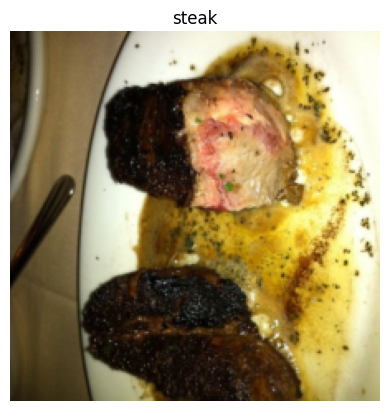

In [16]:
plt.imshow(img.permute(2, 1, 0))
plt.title(class_names[label])
plt.axis('off');

In [17]:
image_out_of_conv = conv2d(img.unsqueeze(0)) #adding batch dimension
print(image_out_of_conv.shape)

torch.Size([1, 768, 14, 14])


In [18]:
# Get a single feature map in tensor form
single_feature_map = image_out_of_conv[:, 0, :, :]
single_feature_map, single_feature_map.requires_grad

(tensor([[[ 0.0237,  0.0646,  0.0619,  0.0547, -0.0090,  0.0739,  0.0426,
            0.0371,  0.0092,  0.0750,  0.0438,  0.0234,  0.0228, -0.0046],
          [ 0.0783,  0.0704,  0.0188,  0.0380,  0.0705,  0.0200, -0.0066,
            0.0672,  0.0364,  0.0386,  0.0318,  0.0385,  0.0263,  0.0234],
          [ 0.0688,  0.0646,  0.0742,  0.0696,  0.0711, -0.0663,  0.0948,
            0.1008,  0.0781,  0.0629,  0.0604,  0.0699, -0.0250,  0.0222],
          [ 0.0632,  0.0599,  0.0453, -0.0464,  0.0455,  0.0283,  0.0198,
            0.0113, -0.0070, -0.0656,  0.0228, -0.0032,  0.0655,  0.0352],
          [ 0.0071,  0.0349, -0.0973,  0.0132, -0.0118,  0.0649,  0.0241,
            0.0367, -0.0197, -0.0578,  0.0419,  0.0438, -0.0628,  0.0134],
          [ 0.0471,  0.0715,  0.0250,  0.0513,  0.0381,  0.0128, -0.0374,
            0.0577,  0.0649,  0.0169,  0.0140,  0.0601, -0.0099,  0.0518],
          [ 0.0469,  0.1314,  0.0673,  0.0716,  0.0694,  0.0854,  0.1243,
            0.0548,  0.0521, -0.

In [19]:
# flatten
flatten = nn.Flatten(start_dim=2)
img_flat = flatten(image_out_of_conv)
print(img_flat.shape)

torch.Size([1, 768, 196])


In [20]:
#Rearrange output of flattened layer
img_flat = img_flat.permute(0, 2, 1)
img_flat.shape

torch.Size([1, 196, 768])

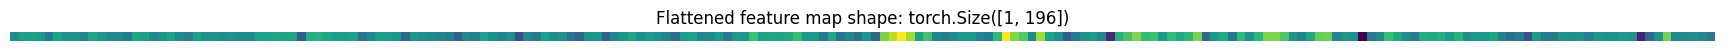

In [21]:
# Get a single flatten feature map
single_flattened_feature_map = img_flat[:, :, 0]

#Plot the flattened feature map
plt.figure(figsize=(22, 22))
plt.imshow(single_flattened_feature_map.detach().numpy())
plt.title(f'Flattened feature map shape: {single_flattened_feature_map.shape}')
plt.axis('off');

In [22]:
first_block = nn.Sequential(
    nn.Conv2d(in_channels=3, #for color images
                   out_channels = 768, #D size from Table 1
                   kernel_size=patch_size,
                   stride=patch_size,
                   padding=0),
    nn.Flatten(start_dim=2)
)

In [23]:
first_block

Sequential(
  (0): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
  (1): Flatten(start_dim=2, end_dim=-1)
)

In [29]:
class PatchEmbedding(nn.Module):
  def __init__(self,
               in_channels: int=3,
               patch_size: int=16,
               embedding_dim: int=768):
    super().__init__()
    self.patch_size = patch_size

    self.patcher = nn.Conv2d(in_channels=in_channels, #for color images
                   out_channels = embedding_dim, #D size from Table 1
                   kernel_size=patch_size,
                   stride=patch_size,
                   padding=0)

    self.flatten = nn.Flatten(start_dim=2)

  def forward(self, x):
    image_resolution = x.shape[-1]
        assert image_resolution % patch_size == 0, f"Input image size must be divisble by patch size, image shape: {image_resolution}, patch size: {patch_size}"

    x_patched = self.patcher(x)
    x_flatten = self.flatten(x_patched)

    return x_flatten.permute(0, 2, 1)



In [28]:
set_seeds()

patchify = PatchEmbedding(in_channels=3,
                          patch_size=16,
                          embedding_dim=768)

patch_embedded_image = patchify(img.unsqueeze(0))
print(patch_embedded_image.shape)

torch.Size([1, 196, 768])


#Creating the ckass token embedding

In [30]:
batch_size = patch_embedded_image.shape[0]
embedding_dimension = patch_embedded_image.shape[-1]

batch_size, embedding_dimension

(1, 768)

In [32]:
class_token = nn.Parameter(torch.ones(batch_size, 1, embedding_dimension),
                           requires_grad=True)
class_token

Parameter containing:
tensor([[[1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
          1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
          1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
          1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
          1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
          1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
          1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
          1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
          1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
          1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
          1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
          1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
          1., 1., 1., 1., 1., 1., 1., 1., 

In [35]:
#add the class token embedding to the front of the patch embedding
patch_embedded_image_with_class_embedding = torch.cat((class_token, patch_embedded_image),
                                                      dim=1) # patch dimention

patch_embedded_image_with_class_embedding.shape, patch_embedded_image_with_class_embedding

(torch.Size([1, 197, 768]),
 tensor([[[ 1.0000,  1.0000,  1.0000,  ...,  1.0000,  1.0000,  1.0000],
          [-0.1952,  0.0514, -0.2195,  ...,  0.1422, -0.0478,  0.0960],
          [-0.2406,  0.0669, -0.2172,  ...,  0.1616, -0.0699,  0.0741],
          ...,
          [-0.8758,  0.1887, -0.1667,  ...,  0.6203, -0.4579,  0.3088],
          [-0.7326,  0.1504, -0.1842,  ...,  0.5617, -0.4006,  0.2795],
          [-0.5911,  0.1154, -0.2173,  ...,  0.4853, -0.3428,  0.3153]]],
        grad_fn=<CatBackward0>))

#Creating the position embedding

In [46]:
#Calculate number of patches
number_of_patches = int((height * width) / patch_size**2)

embedding_dimension = patch_embedded_image_with_class_embedding.shape[-1]

position_embedding = nn.Parameter(torch.ones(1, number_of_patches+1,
                                             embedding_dimension),
                                  requires_grad=True)
position_embedding, position_embedding.shape


(Parameter containing:
 tensor([[[1., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 1., 1., 1.],
          ...,
          [1., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 1., 1., 1.]]], requires_grad=True),
 torch.Size([1, 197, 768]))

In [39]:
#add the position embeding to the patch and class token embedding
patch_and_position_embedding = patch_embedded_image_with_class_embedding + position_embedding

patch_and_position_embedding.shape, patch_and_position_embedding

(torch.Size([1, 197, 768]),
 tensor([[[2.0000, 2.0000, 2.0000,  ..., 2.0000, 2.0000, 2.0000],
          [0.8048, 1.0514, 0.7805,  ..., 1.1422, 0.9522, 1.0960],
          [0.7594, 1.0669, 0.7828,  ..., 1.1616, 0.9301, 1.0741],
          ...,
          [0.1242, 1.1887, 0.8333,  ..., 1.6203, 0.5421, 1.3088],
          [0.2674, 1.1504, 0.8158,  ..., 1.5617, 0.5994, 1.2795],
          [0.4089, 1.1154, 0.7827,  ..., 1.4853, 0.6572, 1.3153]]],
        grad_fn=<AddBackward0>))

#Putting all together

In [54]:
set_seeds()

patch_size = 16

print(f'Image tensor shape {img.shape}')

height, width = img.shape[1], img.shape[-1]

#image tensor and add a batch dimention
x = img.unsqueeze(0)
print(f'Input Image shape {x.shape}')

patch_embedding_layer = PatchEmbedding(in_channels=3,
                                       patch_size=patch_size,
                                       embedding_dim=768)

patch_embedding = patch_embedding_layer(x)
print(f'Patch embedding shape {patch_embedding.shape}')

batch_size = patch_embedding.shape[0]
embedding_dimension = patch_embedding.shape[-1]

class_token = nn.Parameter(torch.ones(batch_size, 1, embedding_dimension),
                           requires_grad=True)

print(f'class token shape {class_token.shape}')
patch_embedded_image_with_class_embedding = torch.cat((class_token, patch_embedding),
                                                      dim=1)
print(f'patch_embedded_image_with_class_embedding shape {patch_embedded_image_with_class_embedding.shape}')
number_of_patches = int((height * width) / patch_size**2)

position_embedding = nn.Parameter(torch.rand(1, number_of_patches+1, embedding_dimension),
                                  requires_grad=True)

patch_and_position_embedding = patch_embedded_image_with_class_embedding + position_embedding

print(f'patch_and_position_embedding shape {patch_and_position_embedding.shape}')
# patch_and_position_embedding, patch_and_position_embedding.shape

Image tensor shape torch.Size([3, 224, 224])
Input Image shape torch.Size([1, 3, 224, 224])
Patch embedding shape torch.Size([1, 196, 768])
class token shape torch.Size([1, 1, 768])
patch_embedded_image_with_class_embedding shape torch.Size([1, 197, 768])
patch_and_position_embedding shape torch.Size([1, 197, 768])


#Equation 2 MSA Block



In [66]:
class MultiheadSelfAttentionBlock(nn.Module):
  def __init__(self,
                 embedding_dim:int=768, # Hidden size D from Table 1 for ViT-Base
                 num_heads:int=12, # Heads from Table 1 for ViT-Base
                 attn_dropout:float=0): # doesn't look like the paper uses any dropout in MSABlocks
    super().__init__()

    #Create norm layer (LN)
    self.layer_norm = nn.LayerNorm(normalized_shape=embedding_dim)

    #Create multihead attention (MSA) layer
    self.multihead_attn = nn.MultiheadAttention(embed_dim=embedding_dim,
                                                num_heads=num_heads,
                                                dropout=attn_dropout,
                                                batch_first=True) # output is (batch, seq, features) => (batch, number_of_patches, embedding_dimention)


  def forward(self, x):
    x = self.layer_norm(x)
    attn_output,_ = self.multihead_attn(query=x,
                                        key=x,
                                        value=x,
                                        need_weights=False)

    return attn_output

In [67]:
#Create an instance

# Create an instance of MSABlock
multihead_self_attention_block = MultiheadSelfAttentionBlock(embedding_dim=768, # from Table 1
                                                             num_heads=12) # from Table 1

# Pass patch and position image embedding through MSABlock
patched_image_through_msa_block = multihead_self_attention_block(patch_and_position_embedding)
print(f"Input shape of MSA block: {patch_and_position_embedding.shape}")
print(f"Output shape MSA block: {patched_image_through_msa_block.shape}")

Input shape of MSA block: torch.Size([1, 197, 768])
Output shape MSA block: torch.Size([1, 197, 768])
